In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pylab import rcParams

#path = '/kaggle'
path = '/tmp/working'
input_path = path + '/input/gearbox-fault-diagnosis-stdev-of-accelerations/'
broken_dataset  = "b30hz_stdev_100.csv"
healthy_dataset = "h30hz_stdev_100.csv"


# Exploring the dataset

In [14]:
healthyDataset = pd.read_csv(input_path + healthy_dataset)
healthyDataset.describe()

,a1,a2,a3,a4,load,failure
count,10154.000000,10154.000000,10154.000000,10154.000000,10154.000000,10154.0
mean,7.064944,4.238840,3.987288,4.343511,45.809533,0.0
std,2.231626,1.326401,1.069945,1.247653,28.315587,0.0
min,1.802930,1.272738,1.022471,1.222780,0.000000,0.0
25%,5.496722,3.337468,3.226538,3.453185,20.000000,0.0
50%,6.856787,4.016475,3.916282,4.275365,50.000000,0.0
75%,8.419728,4.846186,4.689546,5.156541,70.000000,0.0
max,23.909199,10.984053,8.273939,10.609798,90.000000,0.0


In [15]:
brokenDataset = pd.read_csv(input_path + broken_dataset)
brokenDataset.describe()

,a1,a2,a3,a4,load,failure
count,10049.000000,10049.000000,10049.000000,10049.000000,10049.000000,10049.0
mean,4.455177,4.294107,3.706363,4.209203,45.478157,1.0
std,1.202618,0.969298,0.947515,1.205743,29.005078,0.0
min,1.468928,1.341292,0.990336,1.111679,0.000000,1.0
25%,3.595718,3.617281,3.020892,3.358830,20.000000,1.0
50%,4.399122,4.256609,3.646947,4.142668,50.000000,1.0
75%,5.221865,4.949478,4.354815,5.006999,70.000000,1.0
max,10.067158,8.071265,7.425122,10.022236,90.000000,1.0


## Join healthy & broken datasets in a single dataframe

In [16]:
dataset = pd.concat([healthyDataset, brokenDataset], axis=0)
dataset.describe()

,a1,a2,a3,a4,load,failure
count,20203.000000,20203.000000,20203.000000,20203.000000,20203.000000,20203.000000
mean,5.766842,4.266330,3.847555,4.276706,45.644706,0.497401
std,2.219236,1.162870,1.020591,1.228792,28.660383,0.500006
min,1.468928,1.272738,0.990336,1.111679,0.000000,0.000000
25%,4.164285,3.473209,3.118392,3.409206,20.000000,0.000000
50%,5.337988,4.146414,3.779156,4.211713,50.000000,0.000000
75%,7.003621,4.903647,4.521386,5.078614,70.000000,1.000000
max,23.909199,10.984053,8.273939,10.609798,90.000000,1.000000


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


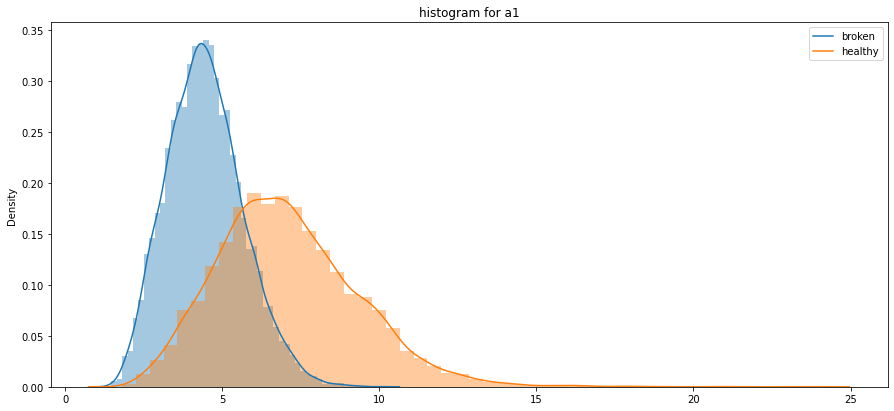

In [24]:
plt.figure(figsize=(15,28*8))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(dataset[['a1']]):
    ax = plt.subplot(gs[i])
    sns.distplot(dataset[cn][dataset.failure == 1], bins=50)
    sns.distplot(dataset[cn][dataset.failure == 0], bins=50)
    ax.set_xlabel('')
    plt.legend(['broken', 'healthy'])
    ax.set_title('histogram for ' + str(cn))
plt.show()

## Correlation matrix

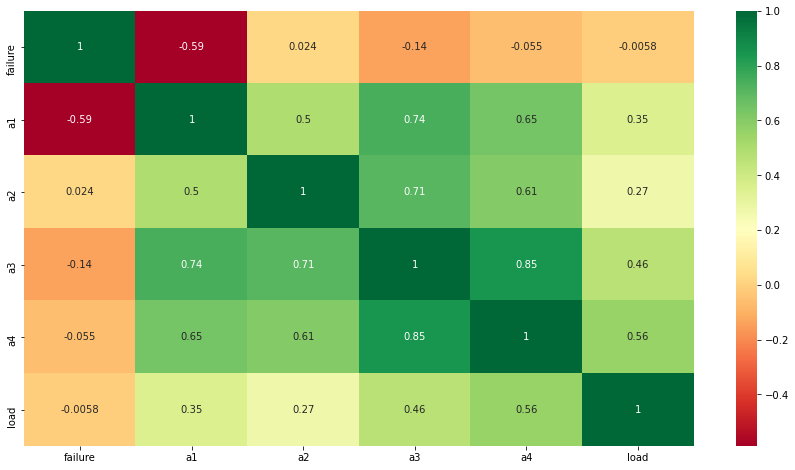

In [26]:
rcParams['figure.figsize'] = 15, 8
columns = ['failure','a1', 'a2', 'a3', 'a4', 'load']
sns.heatmap(dataset[columns].corr(),annot=True,cmap='RdYlGn')
fig=plt.gcf()
plt.show()

# Logistic regression

In [46]:
# Predictor variable (features)
columns = ['a1', 'a2', 'a3', 'a4', 'load']
X = dataset[columns]
# Target variable: Failure (boolean)
#y = dataset.iloc[:,-1]
y = dataset[['failure']]

In [43]:
# Split the dataset: 80% train, 20% test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

# Logistic regression classifier
from sklearn.linear_model import LogisticRegression

# Setup the model
logis = LogisticRegression(max_iter=1000)

# Train the model
logis.fit(X_train,y_train)

# Predict Failrure for the test set
y_pred = logis.predict(X_test)
print("Prediction for the test data (first 10 rows):", y_pred[:10])
print(X_test.iloc[:10,:])

Prediction for the test data (first 10 rows): [1 0 0 0 1 1 0 1 0 0]
            a1        a2        a3        a4  load
9580  3.781529  3.781130  3.344167  3.938913  90.0
772   9.868402  4.094649  4.579666  4.380036   0.0
1884  8.582827  5.575780  4.065654  3.764160  20.0
7292  5.290286  3.291150  2.560785  3.701401  70.0
6029  4.416229  5.346716  4.420307  5.606007  60.0
3295  5.407599  4.939266  4.815380  4.720481  30.0
3928  7.307175  4.537242  3.884218  4.310894  30.0
1659  4.477275  5.284694  4.286651  4.689030  10.0
2054  9.416835  4.139155  4.482785  4.878986  20.0
7530  7.338268  4.706981  4.676121  5.776304  70.0


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


## Confusion matrix

In [44]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred,y_test)
cm

array([[1851,  194],
       [ 167, 1829]])

In [45]:
# .score returns the mean accuracy on the given test data and labels
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
print( logis.score(X_test,y_test) , logis.score(X_train,y_train) )

0.9106656768126701 0.915542630862517


## Classification report

In [23]:
from sklearn.metrics import classification_report
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      2018
           1       0.92      0.90      0.91      2023

    accuracy                           0.91      4041
   macro avg       0.91      0.91      0.91      4041
weighted avg       0.91      0.91      0.91      4041



## ROC curve

In [24]:
# For the ROC curve we need not only the predicted class ('Outcome'), but also the scores on what the predictions are based
# * if threshold 0
#  ** predict>0 => Outcome=1
#  ** predict<0 => Outcome=0 
#  - Remember that predictions were calculated with METHOD .predict(X_test)
#  - Now we also have to include METHOD .decision_function(X_test)
y_pred_score = logis.decision_function(X_test)

In [25]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, auc

# If using the test set (X_test, y_test)
fpr,tpr,threshold= roc_curve(y_test, y_pred_score)

In [26]:
# Area Under Curve
lr_auc = auc(fpr, tpr)
print("AUC=", lr_auc)

AUC= 0.972162303970151


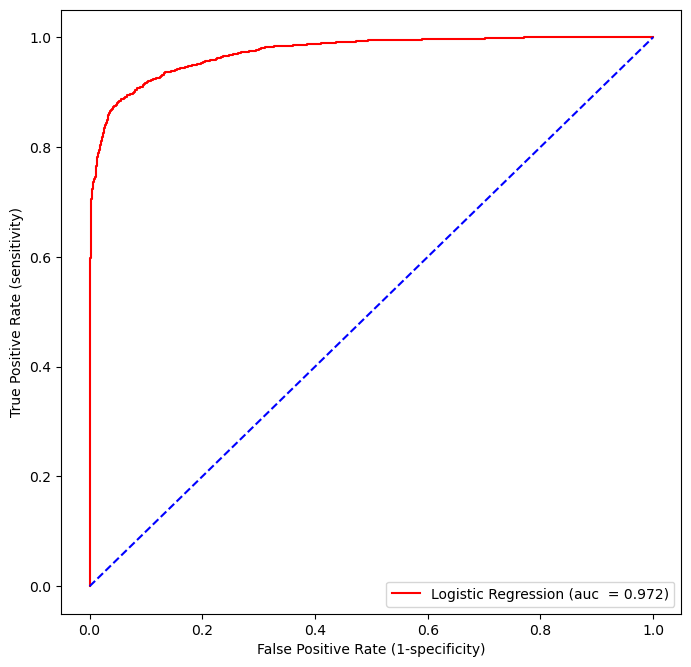

In [27]:
# This default size comes from above
#rcParams['figure.figsize'] = 12, 8

plt.figure(figsize = (8,8), dpi=100)

plt.plot(fpr, tpr, color='red', linestyle='-', label = "Logistic Regression (auc  = %0.3f)"%lr_auc)
plt.plot([0,1],[0,1],color='blue',linestyle='--')

plt.xlabel('False Positive Rate (1-specificity)')
plt.ylabel('True Positive Rate (sensitivity)')

plt.legend()

plt.show()